In [17]:

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.cm as cm
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags
from scipy.linalg import eig  
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

# Manually parse the edgelist file and create the graph with weights

G = nx.Graph()
with open("EU_Air//EUAirTransportation_multiplex.edges", "r") as f:
    for line in f:
        parts = line.strip().split()
        # Use the first two columns as nodes, last column as weight
        node1, node2, weight = parts[1], parts[2], float(parts[3])
        G.add_edge(node1, node2, weight=weight)

node_pos = {}
with open("EU_Air//EUAirTransportation_nodes.txt", "r") as f:
    next(f)  # Skip header line
    for line in f:
        parts = line.strip().split()
        node_id = parts[0]
        lon = float(parts[-2])
        lat = float(parts[-1])
        node_pos[node_id] = (lon, lat)

num_nodes = G.number_of_nodes()
print(f"Number of nodes: {num_nodes}")
num_edges = G.number_of_edges()
print(f"Number of edges: {num_edges}")




Number of nodes: 417
Number of edges: 2953


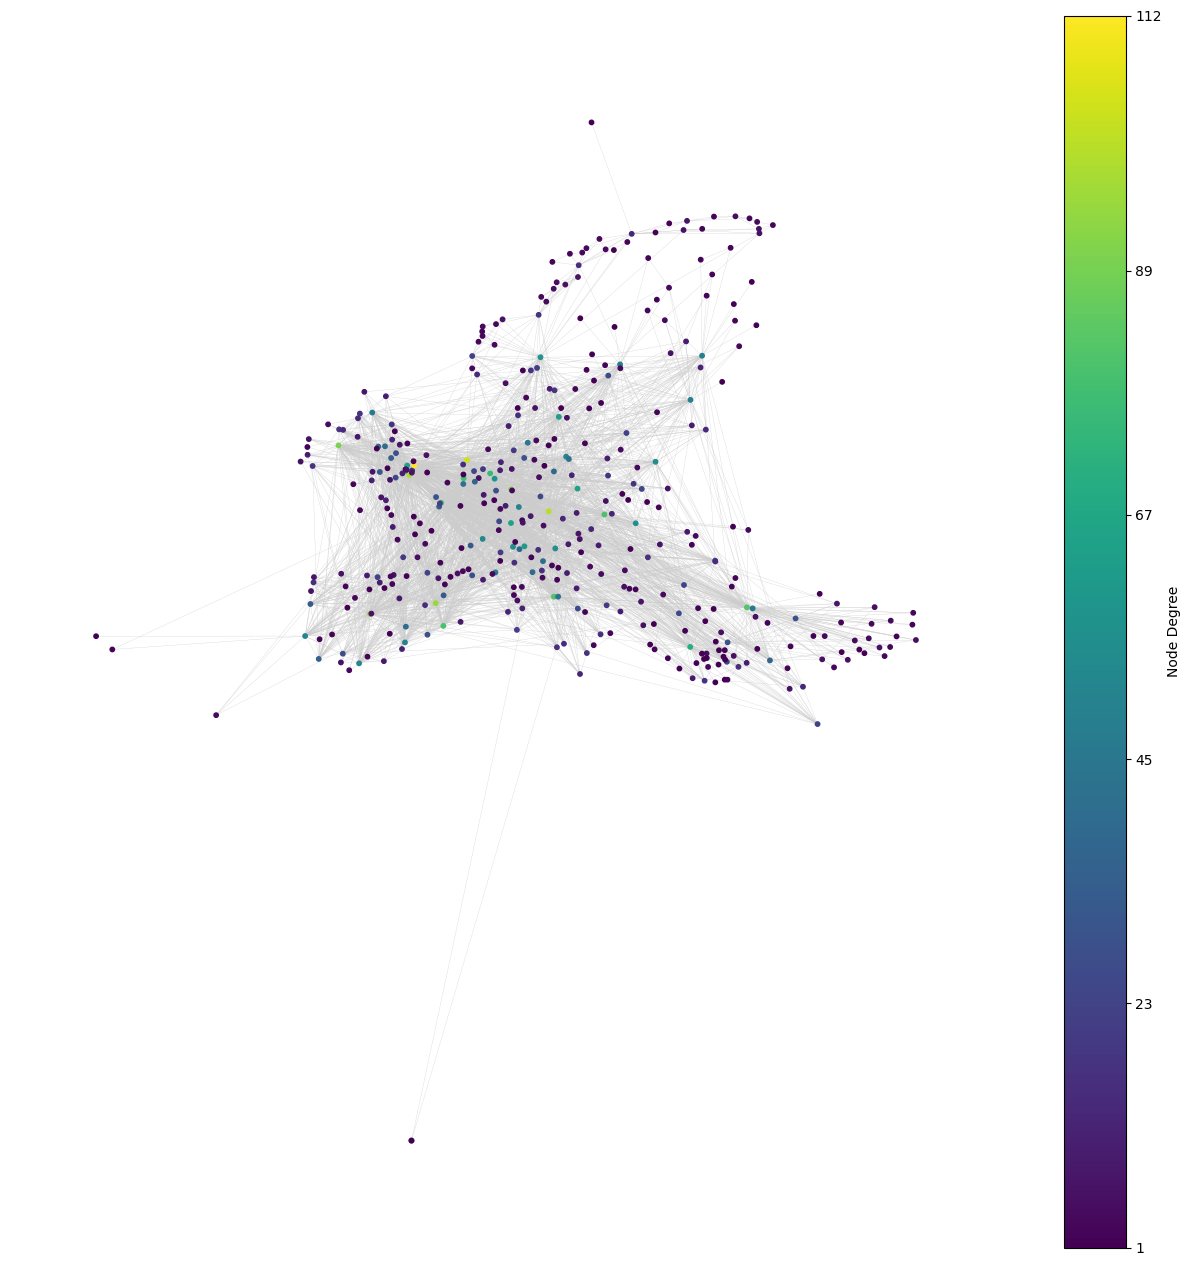

In [2]:
# Visualization with node colors based on degree

fig, ax = plt.subplots(figsize=(16, 16))
degrees = np.array([G.degree(n) for n in G.nodes()])
colors = degrees
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=degrees.min(), vmax=degrees.max())
nodes = nx.draw_networkx(
    G,
    pos=node_pos,
    with_labels=False,
    node_size=10,
    node_color=colors,
    cmap=cmap,
    edge_color='#cccccc',
    width=0.2,
    ax=ax
)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Node Degree', orientation='vertical')
cbar.set_ticks(np.linspace(degrees.min(), degrees.max(), num=6, dtype=int))
plt.show()


C:\Users\runeg\AppData\Local\Temp\ipykernel_21212\2665668087.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(layers))


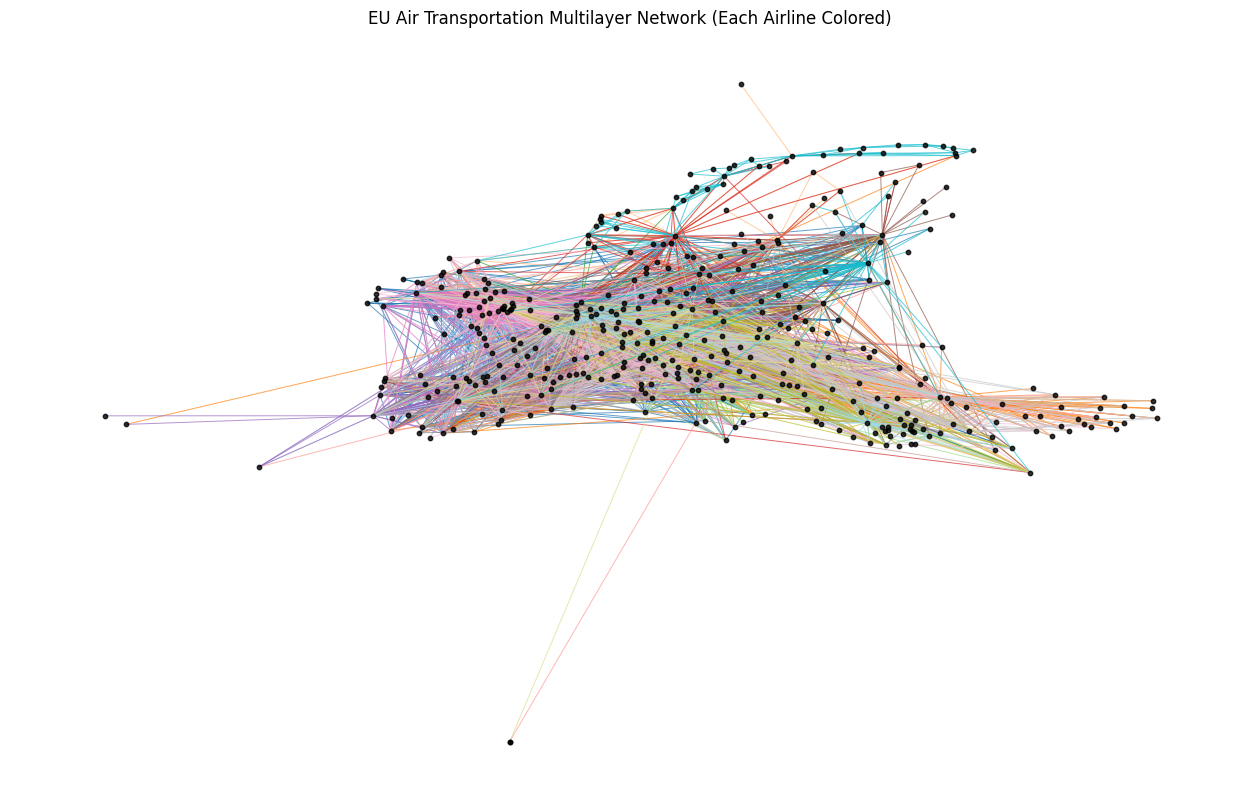

In [3]:
# Visualize multilayer network: color each layer (airline) differently

# Parse edges grouped by layer, but use the Graph object
layer_edges = {}
with open("EU_Air//EUAirTransportation_multiplex.edges", "r") as f:
    for line in f:
        parts = line.strip().split()
        layer = parts[0]
        node1, node2 = parts[1], parts[2]
        layer_edges.setdefault(layer, []).append((node1, node2))

# Assign color per layer
layers = sorted(layer_edges.keys(), key=int)
colors = cm.get_cmap('tab20', len(layers))

fig, ax = plt.subplots(figsize=(16, 10))

for i, layer in enumerate(layers):
    # Build a subgraph for this layer from the original G
    H = nx.Graph()
    H.add_edges_from(layer_edges[layer])
    
    nx.draw_networkx_edges(
        H,
        pos=node_pos,
        edge_color=[colors(i)],
        width=0.7,
        alpha=0.7,
        ax=ax
    )

# Draw all nodes once
nx.draw_networkx_nodes(
    G,
    pos=node_pos,
    node_size=10,
    node_color='black',
    alpha=0.8,
    ax=ax
)

ax.axis('off')
plt.title("EU Air Transportation Multilayer Network (Each Airline Colored)")
plt.show()


In [4]:


def plot_communities(G, community_of, node_pos=None, title="Communities on graph",
                     show_labels=False, edge_alpha=0.15, node_size=18):
    """
    Plot G with nodes colored by community_of[node].
    """

    nodes = list(G.nodes())

    if node_pos is None:
        pos = nx.spring_layout(G, seed=42)
    else:
        pos = node_pos

    nodes_with_pos = [u for u in nodes if u in pos]
    if not nodes_with_pos:
        raise ValueError("No nodes have positions. Provide a valid node_pos.")

    labels = np.array([community_of.get(u, -1) for u in nodes_with_pos])  # -1 for unknown
    known_mask = labels >= 0
    unknown_mask = ~known_mask

    unique_comms = sorted(np.unique(labels[known_mask]))
    comm_to_idx = {c: i for i, c in enumerate(unique_comms)}
    mapped = np.array([comm_to_idx[c] if c in comm_to_idx else -1 for c in labels])

    bright_colors = [
        "#e41a1c", 
        "#377eb8",  
        "#4daf4a",  
        "#984ea3",  
        "#ff7f00",  
        "#ffff33",  
        "#0a0a0a", 
    ]
    cmap = plt.cm.get_cmap("tab10", max(1, len(unique_comms)))  # fallback
    color_list = bright_colors if len(unique_comms) <= len(bright_colors) else cmap.colors

    plt.figure(figsize=(10, 8))

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=[(u, v) for u, v in G.edges() if u in pos and v in pos],
        width=0.4,
        alpha=edge_alpha,
        edge_color="gray",
    )

    xs = [pos[u][0] for u in nodes_with_pos]
    ys = [pos[u][1] for u in nodes_with_pos]

    if known_mask.any():
        plt.scatter(
            np.array(xs)[known_mask],
            np.array(ys)[known_mask],
            c=[color_list[i % len(color_list)] for i in mapped[known_mask]],
            s=node_size,
            alpha=0.95,
        )

    if unknown_mask.any():
        plt.scatter(
            np.array(xs)[unknown_mask],
            np.array(ys)[unknown_mask],
            c="lightgray",
            s=node_size,
            alpha=0.9,
            label="unlabeled",
        )

    if show_labels:
        for u in nodes_with_pos:
            x, y = pos[u]
            plt.text(x, y, str(u), fontsize=6, ha="center", va="center")

    handles = [
        Line2D([0], [0], marker="o", linestyle="", markersize=6,
               label=f"c={c}", markerfacecolor=color_list[i % len(color_list)],
               markeredgecolor="none")
        for i, c in enumerate(unique_comms)
    ]
    if unknown_mask.any():
        handles.append(Line2D([0], [0], marker="o", linestyle="", markersize=6,
                              label="unlabeled", markerfacecolor="lightgray",
                              markeredgecolor="none"))
    if handles:
        plt.legend(handles=handles, title="Communities", loc="best", frameon=True)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()



C:\Users\runeg\AppData\Local\Temp\ipykernel_21212\1548571776.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


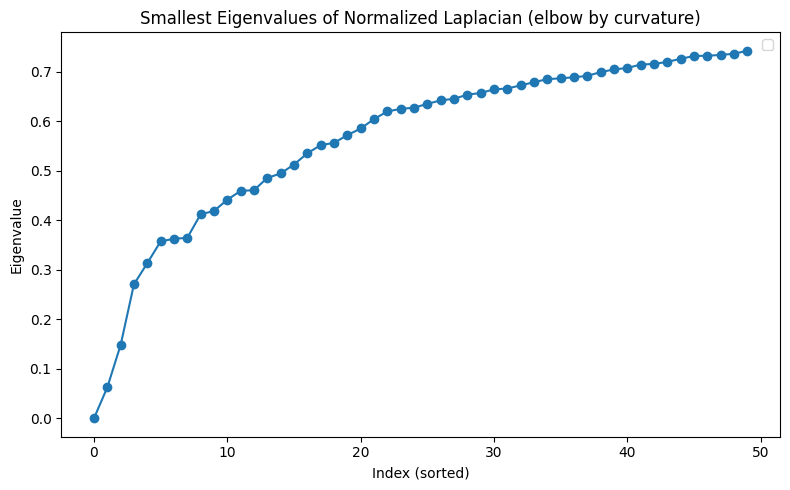

In [5]:
nodes = list(G.nodes())

Lnorm = nx.normalized_laplacian_matrix(G, nodelist=nodes).astype(np.float64)
num_cc = nx.number_connected_components(G)
eigvals, eigvecs = eigsh(Lnorm, k=50, which='SM')   
perm = np.argsort(eigvals)
eigvals = eigvals[perm]
eigvecs = eigvecs[:, perm]

plt.figure(figsize=(8, 5))
plt.plot(range(len(eigvals)), eigvals, marker='o', linestyle='-')

plt.title('Smallest Eigenvalues of Normalized Laplacian (elbow by curvature)')
plt.xlabel('Index (sorted)')
plt.ylabel('Eigenvalue')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:

def pick_k_by_curvature(eigvals, num_cc, return_debug=False):
    """
    Pick K using the curvature (second difference) elbow on the ascending spectrum.
    eigvals : ascending eigenvalues (1D array)
    num_cc  : number of connected components (zeros block size)

    Returns:
      K  (int), and optionally a debug dict.
    """
    lam = np.asarray(eigvals, dtype=float)
    n = lam.size
    start = int(num_cc)

    tail = lam[start:]
    if tail.size < 3:
        gaps = np.diff(tail)
        K = start + (np.argmax(gaps) + 1 if gaps.size else 1)
        if return_debug:
            return int(K), {"start": start, "method": "fallback_gap", "gaps": gaps}
        return int(K)

    second_diff = tail[2:] - 2*tail[1:-1] + tail[:-2]
    elbow_in_tail = int(np.argmax(second_diff)) + 1 
    K = start + elbow_in_tail

    if return_debug:
        return int(K), {
            "start": start,
            "second_diff": second_diff,
            "elbow_in_tail": elbow_in_tail,
            "K": int(K),
        }
    return int(K)


In [21]:

K, dbg = pick_k_by_curvature(eigvals, num_cc, return_debug=True)
print("Chosen K (curvature elbow):", K)



Chosen K (curvature elbow): 7


C:\Users\runeg\AppData\Local\Temp\ipykernel_21212\1736450781.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(1, len(unique_comms)))  # fallback


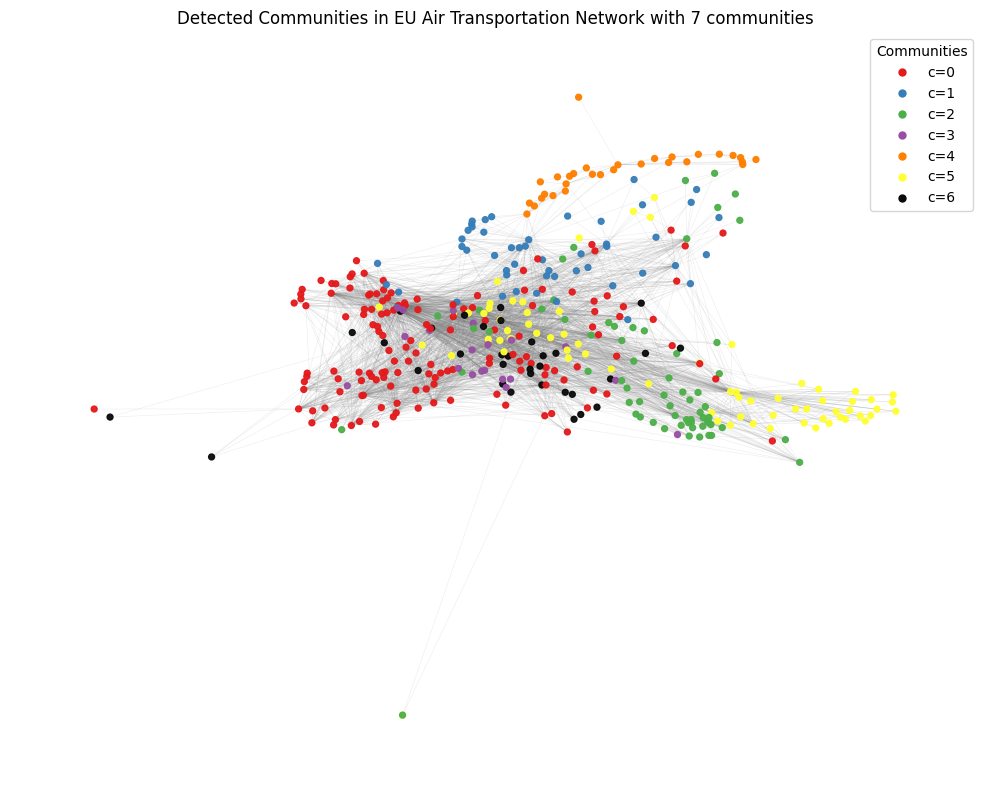

In [22]:
U = eigvecs[:, num_cc:num_cc + K]

row_norms = np.linalg.norm(U, axis=1, keepdims=True)
row_norms[row_norms == 0.0] = 1.0
U_norm = U / row_norms

km = KMeans(n_clusters=K, n_init=20, random_state=0)
labels = km.fit_predict(U_norm)
community_of = {nodes[i]: int(labels[i]) for i in range(len(nodes))}
plot_communities(G, community_of, node_pos=node_pos, title=f"Detected Communities in EU Air Transportation Network with {K} communities", show_labels=False)

C:\Users\runeg\AppData\Local\Temp\ipykernel_21212\1736450781.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(1, len(unique_comms)))  # fallback


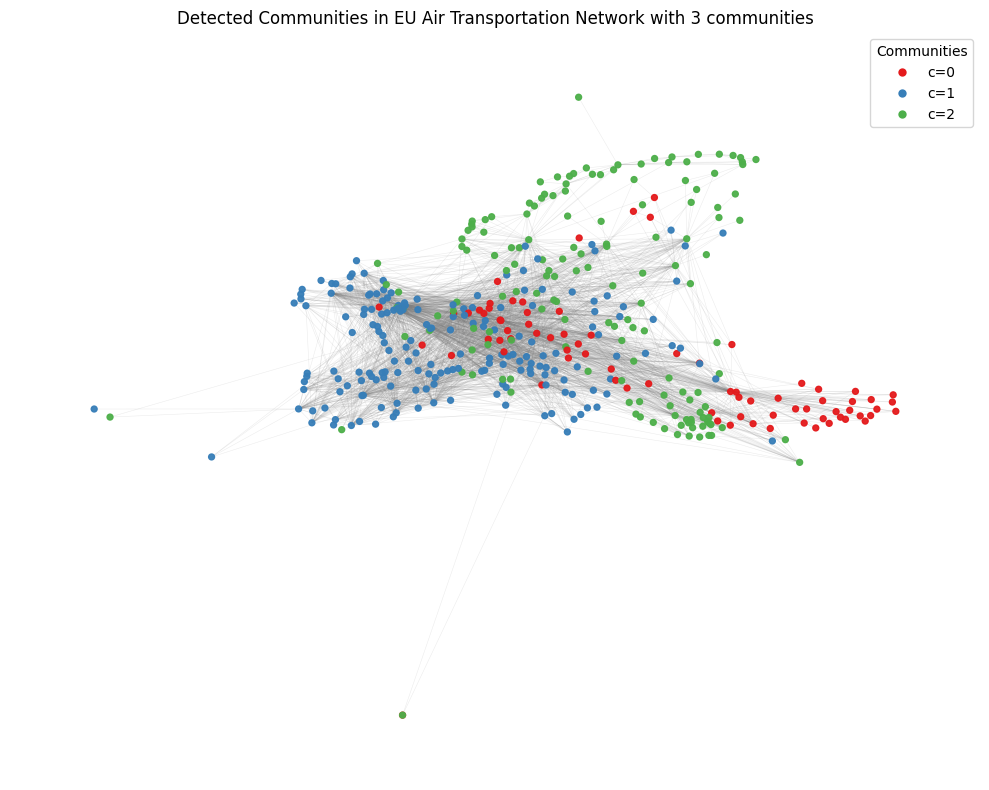

In [24]:

km = KMeans(n_clusters=3, n_init=20, random_state=0)
labels = km.fit_predict(U_norm)
community_of = {nodes[i]: int(labels[i]) for i in range(len(nodes))}
plot_communities(G, community_of, node_pos=node_pos, title=f"Detected Communities in EU Air Transportation Network with {3} communities", show_labels=False)

In [10]:


def lrw_full_spectrum(G, nodes=None, imag_tol=1e-8):
    if nodes is None:
        nodes = list(G.nodes())
    A = nx.to_scipy_sparse_array(G, nodelist=nodes, weight="weight", format="csr")
    deg = np.asarray(A.sum(axis=1)).ravel()
    d_safe = deg.copy(); d_safe[d_safe == 0.0] = 1.0
    Dinv = diags(1.0/d_safe, format="csr")
    L = diags(deg, format="csr") - A
    Lrw = (Dinv @ L).toarray()               

    w, VR = eig(Lrw)                         
    w = np.real(w); VR = np.real(VR)
    w[np.isclose(w, 0.0, atol=imag_tol)] = 0.0  

    order = np.argsort(w)                    
    evals = w[order]
    evecs = VR[:, order]
    num_cc = nx.number_connected_components(G)
    return evals, evecs, nodes, num_cc


Connected components: 1
First 10 eigenvalues: [0.         0.0624397  0.14800049 0.270587   0.31328914 0.35720728
 0.36253765 0.36440655 0.41194773 0.4186762  0.44139725 0.4592476
 0.46067053 0.48538707 0.49435974 0.51246172 0.53500043 0.55159394
 0.55613733 0.57169369]


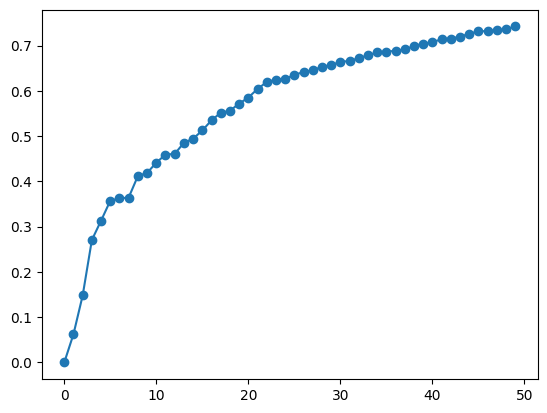

In [11]:
evals_rw, evecs_rw, nodes_rw, num_cc_rw = lrw_full_spectrum(G, nodes=list(G.nodes()))
print("Connected components:", num_cc_rw)
print("First 10 eigenvalues:", evals_rw[:20])   
plt.plot(evals_rw[:50], marker='o')


In [12]:

def pick_k_from_lrw_eigs(evals, num_cc=0, zero_tol=1e-12, return_debug=False):
    """
    Choose K from L_rw eigenvalues (ascending) via the 'first largest eigengap' rule.
    Args:
      evals     : 1D array-like of eigenvalues of L_rw = D^{-1}L, sorted ascending.
      num_cc    : number of connected components (zeros multiplicity). If unknown,
                  we'll infer it from zero_tol.
      zero_tol  : tolerance to count zeros.
      return_debug : if True, also return dict with gaps and indices.

    Returns:
      K : int (chosen number of communities)
      (optional) debug dict with:
         'start' : index after zero block
         'gaps'  : np.diff(tail)
         'gap_idx': index of chosen gap within the tail
    """
    evals = np.asarray(evals, dtype=float)
    if evals.ndim != 1 or evals.size < 2:
        return 1 if return_debug is False else (1, {"start":0, "gaps":np.array([]), "gap_idx":None})

    if num_cc is None or num_cc <= 0:
        num_cc = int((np.abs(evals) <= zero_tol).sum())

    if num_cc >= len(evals) - 1:
        return max(1, num_cc) if return_debug is False else (max(1, num_cc),
               {"start":num_cc, "gaps":np.array([]), "gap_idx":None})

    tail = evals[num_cc:]              
    gaps = np.diff(tail)               

    if gaps.size == 0:
        return max(1, num_cc) if return_debug is False else (max(1, num_cc),
               {"start":num_cc, "gaps":gaps, "gap_idx":None})

    j = int(np.argmax(gaps))           
    K = num_cc + j + 1                

    if return_debug:
        return int(K), {"start": num_cc, "gaps": gaps, "gap_idx": j}
    return int(K)


In [28]:

K, dbg = pick_k_from_lrw_eigs(evals_rw, num_cc=num_cc, return_debug=True)
print("Connected components:", num_cc)
print("Chosen K (first largest gap):", K)



Connected components: 1
Chosen K (first largest gap): 3


In [26]:
def pick_k_with_dominance(evals, num_cc=0, zero_tol=1e-12, min_ratio=1.25):
    """
    Like pick_k_from_lrw_eigs but requires the chosen gap to be at least
    'min_ratio' times larger than any *previous* gap. If not found, falls back
    to the global maximum (first occurrence). This is taken from the slides.
    """
    K, dbg = pick_k_from_lrw_eigs(evals, num_cc=num_cc, zero_tol=zero_tol, return_debug=True)
    start = dbg["start"]; gaps = dbg["gaps"]; j = dbg["gap_idx"]
    if gaps.size == 0: 
        return K
    if j > 0 and np.max(gaps[:j]) * min_ratio > gaps[j]:
        return K
    return K
print("Chosen K (dominant gap):", pick_k_with_dominance(evals_rw, num_cc=num_cc))

Chosen K (dominant gap): 3


C:\Users\runeg\AppData\Local\Temp\ipykernel_21212\1736450781.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(1, len(unique_comms)))  # fallback


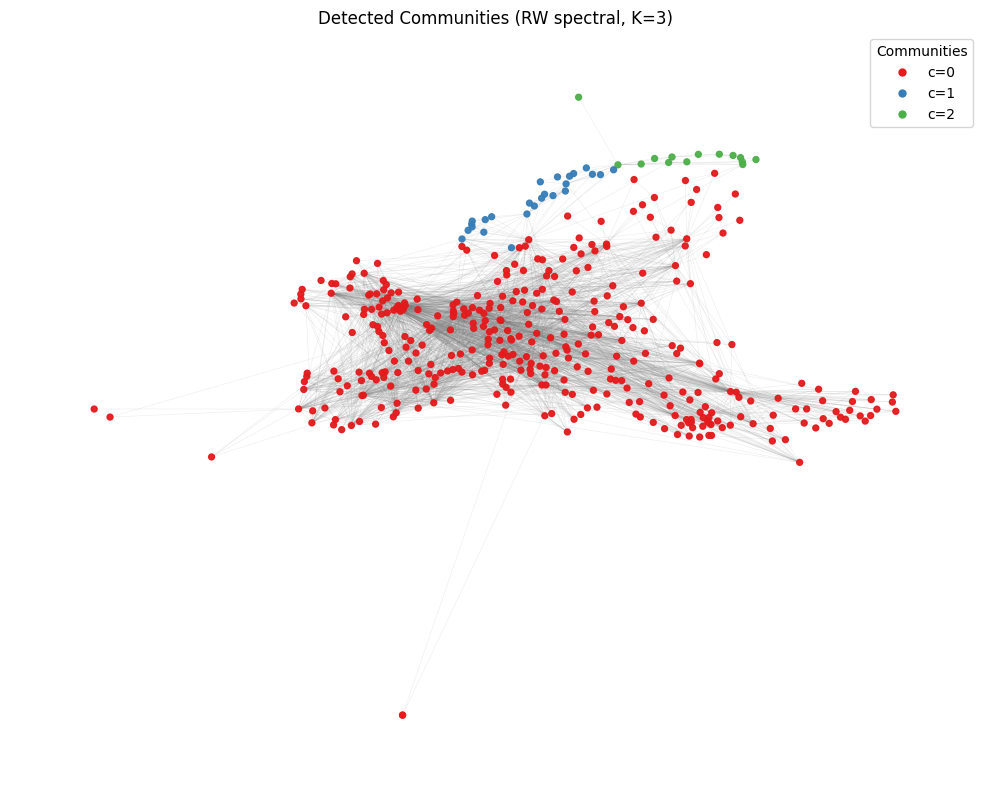

In [29]:
U = evecs_rw[:, :K].astype(float, copy=False)
r = np.linalg.norm(U, axis=1, keepdims=True); r[r == 0.0] = 1.0
U_norm = U / r

km = KMeans(n_clusters=K, n_init=20, random_state=0)
labels = km.fit_predict(U_norm)

community_of = {nodes[i]: int(labels[i]) for i in range(len(nodes))}

plot_communities(
    G,
    community_of,
    node_pos=node_pos,
    title=f"Detected Communities (RW spectral, K={K})",
    show_labels=False
)

C:\Users\runeg\AppData\Local\Temp\ipykernel_21212\1736450781.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(1, len(unique_comms)))  # fallback


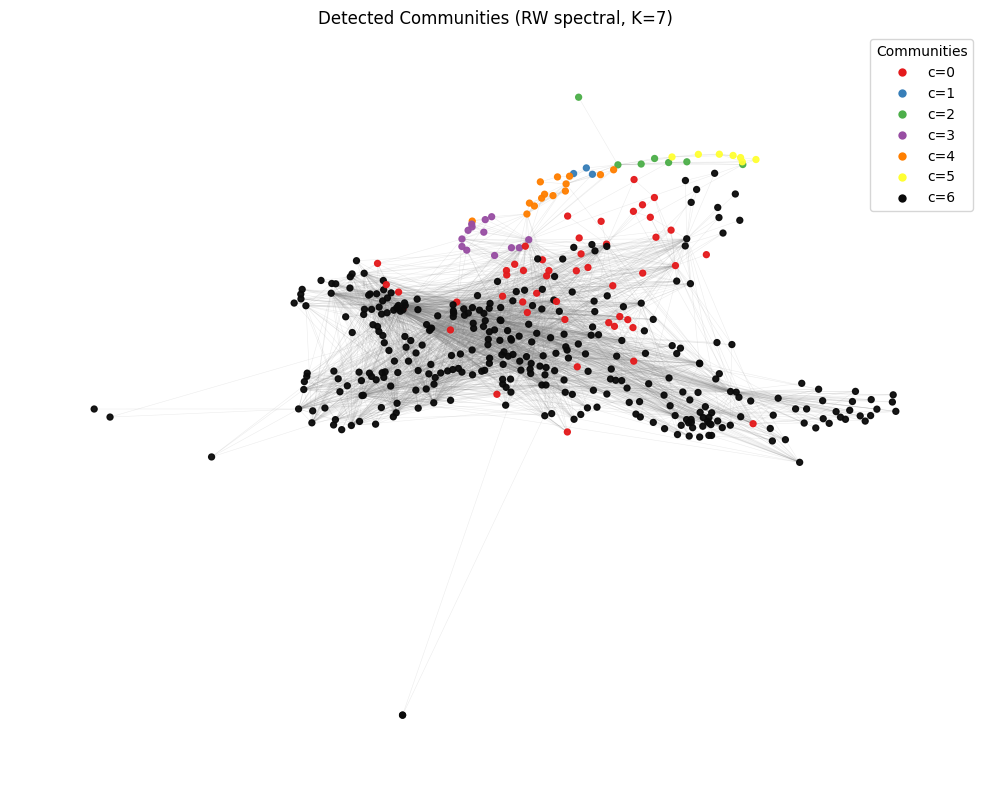

In [30]:
km = KMeans(n_clusters=7, n_init=20, random_state=0)
labels = km.fit_predict(U_norm)

community_of = {nodes[i]: int(labels[i]) for i in range(len(nodes))}

plot_communities(
    G,
    community_of,
    node_pos=node_pos,
    title=f"Detected Communities (RW spectral, K={7})",
    show_labels=False
)